# BMW News Q&A Evaluation
---

This notebook evaluates both the **original fine-tuned model** and the **pruned (reduced layer) fine-tuned model** on a BMW News Q&A benchmark.

## Evaluation Metrics:
1. **Accuracy**: For multiple-choice and factual questions
2. **Average Log-Likelihood**: Measures model confidence on correct answers


In [3]:
import os
import sys
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForCausalLM

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# =============================================================================
# Configuration
# =============================================================================

# Model paths
ORIGINAL_MODEL_PATH = "YOUR_FILE_MODEL"
PRUNED_MODEL_PATH = "YOUR_FILE_MODEL"

# Q&A dataset path
QA_DATASET_PATH = "../datasets/bmw_qa_evaluation_set.json"

# Output paths
OUTPUT_DIR_ORIGINAL = "results"
OUTPUT_DIR_PRUNED = "results"

# Generation settings
MAX_NEW_TOKENS = 64
TEMPERATURE = 0.1  # Low temperature for more deterministic answers


In [5]:
# =============================================================================
# Load Q&A Dataset
# =============================================================================

with open(QA_DATASET_PATH, 'r') as f:
    qa_data = json.load(f)

questions = qa_data['questions']
print(f"✓ Loaded {len(questions)} questions")

# Count by category
categories = {}
for q in questions:
    cat = q['category']
    categories[cat] = categories.get(cat, 0) + 1

print(f"\nQuestion categories:")
for cat, count in categories.items():
    print(f"  - {cat}: {count}")


✓ Loaded 20 questions

Question categories:
  - multiple_choice: 10
  - factual: 10


In [6]:
# =============================================================================
# Prompt Templates for Different Question Types
# =============================================================================

def create_qa_prompt(question_data):
    """Create a prompt based on question type."""
    category = question_data['category']
    question = question_data['question']
    
    if category == 'multiple_choice':
        options = question_data['options']
        options_str = "\n".join([f"  {chr(65+i)}. {opt}" for i, opt in enumerate(options)])
        prompt = f"""Answer the following BMW-related question by selecting the correct option.

Question: {question}

Options:
{options_str}

Answer with only the letter (A, B, C, or D):"""
    
    elif category == 'yes_no':
        prompt = f"""Answer the following BMW-related question with Yes or No.

Question: {question}

Answer (Yes or No):"""
    
    else:  # factual
        prompt = f"""Answer the following BMW-related question concisely.

Question: {question}

Answer:"""
    
    return prompt

# Test prompt creation
print("Example prompts:")
print("="*60)
for cat in ['factual', 'multiple_choice']:
    q = next(q for q in questions if q['category'] == cat)
    print(f"\n[{cat.upper()}]")
    print(create_qa_prompt(q))
    print("-"*60)


Example prompts:

[FACTUAL]
Answer the following BMW-related question concisely.

Question: What is the horsepower of the BMW M2?

Answer:
------------------------------------------------------------

[MULTIPLE_CHOICE]
Answer the following BMW-related question by selecting the correct option.

Question: What is the name of the BMW M safety car for MotoGP in 2023?

Options:
  A. BMW M2
  B. BMW M3
  C. BMW M4
  D. BMW M5

Answer with only the letter (A, B, C, or D):
------------------------------------------------------------


In [7]:
# =============================================================================
# Helper Functions
# =============================================================================

def load_model_and_tokenizer(model_path):
    """Load model and tokenizer from path."""
    print(f"Loading model from: {model_path}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    model.eval()
    
    # Set pad token if not set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    print(f"✓ Model loaded. Parameters: {model.num_parameters():,}")
    return model, tokenizer


def generate_answer(model, tokenizer, prompt, max_new_tokens=64, temperature=0.1):
    """Generate answer from model."""
    # Format as chat if using instruct model
    messages = [
        {"role": "system", "content": "You are an expert on BMW and automotive news. Answer questions accurately and concisely."},
        {"role": "user", "content": prompt}
    ]
    
    # Apply chat template
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=temperature > 0,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode only new tokens
    generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return generated.strip()


def compute_log_likelihood(model, tokenizer, prompt, answer):
    """Compute average log-likelihood of answer given prompt."""
    # Format as chat
    messages = [
        {"role": "system", "content": "You are an expert on BMW and automotive news. Answer questions accurately and concisely."},
        {"role": "user", "content": prompt}
    ]
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Full text = prompt + answer
    full_text = formatted_prompt + answer
    
    # Tokenize
    prompt_ids = tokenizer(formatted_prompt, return_tensors="pt").input_ids.to(model.device)
    full_ids = tokenizer(full_text, return_tensors="pt").input_ids.to(model.device)
    
    # Get the answer token positions
    answer_start = prompt_ids.shape[1]
    
    with torch.no_grad():
        outputs = model(full_ids)
        logits = outputs.logits
    
    # Compute log probabilities for answer tokens
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    
    # Get log prob of each answer token
    answer_log_probs = []
    for i in range(answer_start, full_ids.shape[1]):
        if i > 0:  # Skip first token since we predict next token
            token_id = full_ids[0, i]
            log_prob = log_probs[0, i-1, token_id].item()
            answer_log_probs.append(log_prob)
    
    if len(answer_log_probs) == 0:
        return 0.0
    
    avg_log_likelihood = np.mean(answer_log_probs)
    return avg_log_likelihood


In [8]:
# =============================================================================
# Answer Evaluation Functions
# =============================================================================

def normalize_answer(answer):
    """Normalize answer for comparison."""
    answer = answer.strip().lower()
    # Remove punctuation
    answer = answer.rstrip('.,:;!')
    return answer


def evaluate_multiple_choice(generated, question_data):
    """Evaluate multiple choice answer."""
    correct_idx = question_data['answer_index']
    correct_letter = chr(65 + correct_idx)  # A, B, C, D
    correct_answer = question_data['answer']
    options = question_data['options']
    
    gen_norm = normalize_answer(generated)
    
    # Method 1: Check if answer STARTS with the correct letter (A, B, C, D)
    # Must be just the letter, or letter followed by punctuation/space
    if gen_norm:
        first_char = gen_norm[0].upper()
        if first_char == correct_letter:
            if len(gen_norm) == 1 or gen_norm[1] in '.):, \t':
                return True, correct_letter
    
    # Method 2: Check if the EXACT correct answer text matches
    # Must match the full option text, not partial
    if correct_answer.lower() == gen_norm:
        return True, correct_letter
    
    # Method 3: Check if generated contains the correct answer AND NOT other options
    correct_in_gen = correct_answer.lower() in gen_norm
    other_options_in_gen = any(
        opt.lower() in gen_norm 
        for i, opt in enumerate(options) 
        if i != correct_idx
    )
    
    # Only count as correct if correct answer is present and no other options
    if correct_in_gen and not other_options_in_gen:
        return True, correct_letter
    
    return False, correct_letter


def evaluate_yes_no(generated, question_data):
    """Evaluate yes/no answer."""
    correct = question_data['answer'].lower()
    gen_norm = normalize_answer(generated)
    
    # Check the FIRST word or clear yes/no indication
    first_word = gen_norm.split()[0] if gen_norm.split() else ""
    
    if correct == 'yes':
        if first_word in ['yes', 'yes,', 'yes.']:
            return True, correct
        # Only accept if "yes" is present and "no" is not the first word
        if 'yes' in gen_norm and first_word != 'no':
            return True, correct
    
    if correct == 'no':
        if first_word in ['no', 'no,', 'no.']:
            return True, correct
        # Check for "no" but exclude phrases like "no problem" when answer should be yes
        if gen_norm.startswith('no'):
            return True, correct
    
    return False, correct


def evaluate_factual(generated, question_data):
    """Evaluate factual answer - STRICT matching."""
    correct = normalize_answer(question_data['answer'])
    gen_norm = normalize_answer(generated)
    
    # Method 1: Exact match - correct answer appears in generated
    if correct in gen_norm:
        return True, question_data['answer']
    
    # Method 2: For numeric answers, check if the number matches
    import re
    correct_numbers = re.findall(r'\d+', correct)
    gen_numbers = re.findall(r'\d+', gen_norm)
    
    if correct_numbers and correct_numbers == gen_numbers:
        # Numbers match - could be correct
        return True, question_data['answer']
    
    # Method 3: For named entities (names, places), require exact key term match
    # Extract the most important word (usually the last distinctive word)
    correct_words = correct.split()
    
    # Filter out common words
    stopwords = {'the', 'a', 'an', 'bmw', 'group', 'plant', 'of', 'and', 'for', 'in', 'at'}
    key_words = [w for w in correct_words if w.lower() not in stopwords]
    
    if key_words:
        # ALL key words must be present (strict matching)
        all_key_words_present = all(kw.lower() in gen_norm for kw in key_words)
        if all_key_words_present:
            return True, question_data['answer']
    
    return False, question_data['answer']


def evaluate_answer(generated, question_data):
    """Evaluate answer based on question type."""
    category = question_data['category']
    
    if category == 'multiple_choice':
        return evaluate_multiple_choice(generated, question_data)
    elif category == 'yes_no':
        return evaluate_yes_no(generated, question_data)
    else:  # factual
        return evaluate_factual(generated, question_data)


In [9]:
# =============================================================================
# Main Evaluation Function
# =============================================================================

def evaluate_model_on_qa(model, tokenizer, questions, model_name="Model"):
    """Evaluate model on Q&A set."""
    results = []
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    
    for q in tqdm(questions, desc="Evaluating"):
        prompt = create_qa_prompt(q)
        
        # Generate answer
        generated = generate_answer(model, tokenizer, prompt, MAX_NEW_TOKENS, TEMPERATURE)
        
        # Evaluate accuracy
        is_correct, correct_answer = evaluate_answer(generated, q)
        
        # Compute log-likelihood of correct answer
        log_likelihood = compute_log_likelihood(model, tokenizer, prompt, q['answer'])
        
        results.append({
            'id': q['id'],
            'category': q['category'],
            'difficulty': q['difficulty'],
            'question': q['question'],
            'correct_answer': correct_answer,
            'generated_answer': generated,
            'is_correct': is_correct,
            'log_likelihood': log_likelihood
        })
    
    return results


In [ ]:
# =============================================================================
# Evaluate Original (Full) Model
# =============================================================================

print("\n" + "="*80)
print("LOADING ORIGINAL FINE-TUNED MODEL (Full Layers)")
print("="*80)

model_original, tokenizer_original = load_model_and_tokenizer(ORIGINAL_MODEL_PATH)
results_original = evaluate_model_on_qa(model_original, tokenizer_original, questions, "Original Fine-tuned")

# Free memory
del model_original
torch.cuda.empty_cache()


In [ ]:
# =============================================================================
# Evaluate Pruned (Less Layer) Model
# =============================================================================

print("\n" + "="*80)
print("LOADING PRUNED FINE-TUNED MODEL (Reduced Layers)")
print("="*80)

model_pruned, tokenizer_pruned = load_model_and_tokenizer(PRUNED_MODEL_PATH)
results_pruned = evaluate_model_on_qa(model_pruned, tokenizer_pruned, questions, "Pruned Fine-tuned")

# Free memory
del model_pruned
torch.cuda.empty_cache()


In [10]:
# =============================================================================
# Compute Metrics
# =============================================================================

def compute_qa_metrics(results, model_name):
    """Compute Q&A metrics from results."""
    metrics = {
        'model_name': model_name,
        'total_questions': len(results),
        'overall_accuracy': np.mean([r['is_correct'] for r in results]),
        'avg_log_likelihood': np.mean([r['log_likelihood'] for r in results]),
    }
    
    # Per-category metrics
    for category in ['factual', 'multiple_choice']:
        cat_results = [r for r in results if r['category'] == category]
        if cat_results:
            metrics[f'{category}_accuracy'] = np.mean([r['is_correct'] for r in cat_results])
            metrics[f'{category}_avg_ll'] = np.mean([r['log_likelihood'] for r in cat_results])
    
    # Per-difficulty metrics
    for diff in ['easy', 'medium', 'hard']:
        diff_results = [r for r in results if r['difficulty'] == diff]
        if diff_results:
            metrics[f'{diff}_accuracy'] = np.mean([r['is_correct'] for r in diff_results])
    
    return metrics


metrics_original = compute_qa_metrics(results_original, "Original Fine-tuned")
metrics_pruned = compute_qa_metrics(results_pruned, "Pruned Fine-tuned")

print("\n" + "="*80)
print("Q&A EVALUATION RESULTS")
print("="*80)



Q&A EVALUATION RESULTS


In [11]:
# =============================================================================
# Display Results Comparison
# =============================================================================

# Create comparison DataFrame
comparison_data = {
    'Metric': [
        'Overall Accuracy',
        'Avg Log-Likelihood',
        'Factual Accuracy',
        'Multiple Choice Accuracy',
        'Easy Accuracy',
        'Medium Accuracy',
        'Hard Accuracy'
    ],
    'Original Model': [
        f"{metrics_original['overall_accuracy']:.2%}",
        f"{metrics_original['avg_log_likelihood']:.4f}",
        f"{metrics_original.get('factual_accuracy', 0):.2%}",
        f"{metrics_original.get('multiple_choice_accuracy', 0):.2%}",
        f"{metrics_original.get('easy_accuracy', 0):.2%}",
        f"{metrics_original.get('medium_accuracy', 0):.2%}",
        f"{metrics_original.get('hard_accuracy', 0):.2%}"
    ],
    'Pruned Model': [
        f"{metrics_pruned['overall_accuracy']:.2%}",
        f"{metrics_pruned['avg_log_likelihood']:.4f}",
        f"{metrics_pruned.get('factual_accuracy', 0):.2%}",
        f"{metrics_pruned.get('multiple_choice_accuracy', 0):.2%}",
        f"{metrics_pruned.get('easy_accuracy', 0):.2%}",
        f"{metrics_pruned.get('medium_accuracy', 0):.2%}",
        f"{metrics_pruned.get('hard_accuracy', 0):.2%}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Q&A Evaluation Comparison:")
print(comparison_df.to_string(index=False))



📊 Q&A Evaluation Comparison:
                  Metric Original Model Pruned Model
        Overall Accuracy         25.00%       35.00%
      Avg Log-Likelihood        -2.7937      -3.2579
        Factual Accuracy         10.00%       10.00%
Multiple Choice Accuracy         40.00%       60.00%
           Easy Accuracy         40.00%       60.00%
         Medium Accuracy          0.00%       14.29%
           Hard Accuracy         33.33%        0.00%


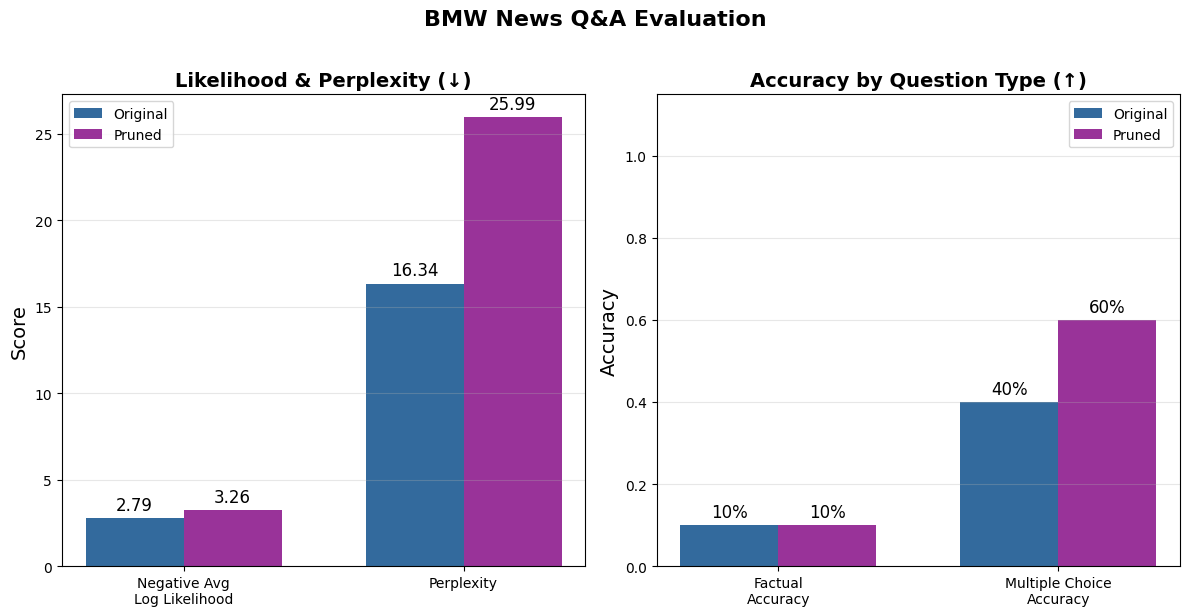


✓ Saved visualization to: ../bmw-llama-3.2-1b-2000articles_stretch/qa_evaluation_comparison.png


In [21]:
# =============================================================================
# Visualization
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Colors - BMW Blue for Original, Purple for Pruned
colors = ['#004585', '#800080']
width = 0.35

# Left figure: Likelihood and Perplexity
ax = axes[0]
ll_names = ['Negative Avg\nLog Likelihood', 'Perplexity']
original_ll = [
    -metrics_original['avg_log_likelihood'],
    np.exp(-metrics_original['avg_log_likelihood'])
]
pruned_ll = [
    -metrics_pruned['avg_log_likelihood'],
    np.exp(-metrics_pruned['avg_log_likelihood'])
]

x = np.arange(len(ll_names))
bars1 = ax.bar(x - width/2, original_ll, width, label='Original', color=colors[0], alpha=0.8)
bars2 = ax.bar(x + width/2, pruned_ll, width, label='Pruned', color=colors[1], alpha=0.8)

ax.set_ylabel('Score', fontsize=14)
ax.set_title('Likelihood & Perplexity (↓)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ll_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Right figure: Accuracy
ax = axes[1]
acc_names = ['Factual\nAccuracy', 'Multiple Choice\nAccuracy']
original_acc = [
    metrics_original.get('factual_accuracy', 0),
    metrics_original.get('multiple_choice_accuracy', 0)
]
pruned_acc = [
    metrics_pruned.get('factual_accuracy', 0),
    metrics_pruned.get('multiple_choice_accuracy', 0)
]

x = np.arange(len(acc_names))
bars1 = ax.bar(x - width/2, original_acc, width, label='Original', color=colors[0], alpha=0.8)
bars2 = ax.bar(x + width/2, pruned_acc, width, label='Pruned', color=colors[1], alpha=0.8)

ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Accuracy by Question Type (↑)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(acc_names)
ax.legend()
ax.set_ylim(0, 1.15)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.0%}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)

plt.suptitle('BMW News Q&A Evaluation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(OUTPUT_DIR_ORIGINAL, "qa_evaluation_comparison.png"), dpi=300, bbox_inches="tight")
plt.show()
print(f"\n✓ Saved visualization to: {OUTPUT_DIR_ORIGINAL}/qa_evaluation_comparison.png")


In [ ]:
# =============================================================================
# Display Detailed Results (Sample)
# =============================================================================

print("\n" + "="*100)
print("DETAILED Q&A RESULTS (First 5 Questions)")
print("="*100)

for i, (orig, prun) in enumerate(zip(results_original[:5], results_pruned[:5])):
    q = questions[i]
    print(f"\n[Q{q['id']}] ({q['category']}, {q['difficulty']})")
    print(f"Question: {q['question']}")
    print(f"Correct Answer: {orig['correct_answer']}")
    print(f"\nOriginal Model: {'✓' if orig['is_correct'] else '✗'} | LL: {orig['log_likelihood']:.4f}")
    gen_orig = orig['generated_answer'][:100] + "..." if len(orig['generated_answer']) > 100 else orig['generated_answer']
    print(f"  Generated: {gen_orig}")
    print(f"\nPruned Model: {'✓' if prun['is_correct'] else '✗'} | LL: {prun['log_likelihood']:.4f}")
    gen_prun = prun['generated_answer'][:100] + "..." if len(prun['generated_answer']) > 100 else prun['generated_answer']
    print(f"  Generated: {gen_prun}")
    print("-"*100)


In [ ]:
# =============================================================================
# Save Results
# =============================================================================

# Save detailed results
output_results = {
    'evaluation_date': '2026-01-05',
    'qa_dataset': QA_DATASET_PATH,
    'models': {
        'original': {
            'path': ORIGINAL_MODEL_PATH,
            'metrics': metrics_original,
            'detailed_results': results_original
        },
        'pruned': {
            'path': PRUNED_MODEL_PATH,
            'metrics': metrics_pruned,
            'detailed_results': results_pruned
        }
    }
}

# Save to both directories
for output_dir in [OUTPUT_DIR_ORIGINAL, OUTPUT_DIR_PRUNED]:
    output_path = os.path.join(output_dir, "qa_evaluation_results.json")
    with open(output_path, 'w') as f:
        json.dump(output_results, f, indent=2)
    print(f"✓ Saved results to: {output_path}")

# Save comparison CSV
comparison_df.to_csv(os.path.join(OUTPUT_DIR_ORIGINAL, "qa_evaluation_comparison.csv"), index=False)
print(f"✓ Saved comparison CSV to: {OUTPUT_DIR_ORIGINAL}/qa_evaluation_comparison.csv")


In [ ]:
# =============================================================================
# Summary
# =============================================================================

print("\n" + "="*80)
print("📊 SUMMARY: BMW News Q&A Evaluation")
print("="*80)

print(f"\n📌 Total Questions: {len(questions)}")
print(f"   - Factual: {sum(1 for q in questions if q['category'] == 'factual')}")
print(f"   - Multiple Choice: {sum(1 for q in questions if q['category'] == 'multiple_choice')}")

print(f"\n🎯 Overall Results:")
print(f"   Original Model Accuracy: {metrics_original['overall_accuracy']:.1%}")
print(f"   Pruned Model Accuracy:   {metrics_pruned['overall_accuracy']:.1%}")
print(f"   Difference: {(metrics_original['overall_accuracy'] - metrics_pruned['overall_accuracy'])*100:+.1f}%")

print(f"\n📈 Average Log-Likelihood (higher = more confident):")
print(f"   Original Model: {metrics_original['avg_log_likelihood']:.4f}")
print(f"   Pruned Model:   {metrics_pruned['avg_log_likelihood']:.4f}")

winner = "Original" if metrics_original['overall_accuracy'] > metrics_pruned['overall_accuracy'] else \
         ("Pruned" if metrics_pruned['overall_accuracy'] > metrics_original['overall_accuracy'] else "Tie")
print(f"\n🏆 Winner: {winner} Model")

print("\n" + "="*80)
